In [1]:
!pip install -qq "arize-phoenix[eval,llama-index]" "openai>=1" pyvis datasets pycm requests 'httpx<0.28'

In [2]:
import os
from getpass import getpass

if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

In [3]:
# Standard library imports
import re

# Third-party library imports
from typing import Any, Dict, List, Optional, Set, Tuple, cast

import nest_asyncio
import pandas as pd

# Local module imports
from llama_index.core import SQLDatabase
from llama_index.core.agent import (
    AgentChatResponse,
    AgentRunner,
    QueryPipelineAgentWorker,
    ReActChatFormatter,
    Task,
)
from llama_index.core.agent.react.output_parser import ReActOutputParser
from llama_index.core.agent.react.types import (
    ObservationReasoningStep,
    ResponseReasoningStep,
)
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core.query_engine import NLSQLTableQueryEngine
from llama_index.core.query_pipeline import (
    AgentFnComponent,
    AgentInputComponent,
    CustomAgentComponent,
    QueryComponent,
    QueryPipeline,
    ToolRunnerComponent,
)
from llama_index.core.tools import BaseTool, QueryEngineTool
from llama_index.llms.openai import OpenAI
from sqlalchemy import create_engine
from tqdm import tqdm

import phoenix as px

# Apply settings and initializations
pd.set_option("display.max_colwidth", 1000)
nest_asyncio.apply()

In [4]:
import os
import tempfile
import zipfile
from io import BytesIO

import matplotlib.pyplot as plt
import pandas as pd
import requests

In [5]:
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

from phoenix.evals import (
    SQL_GEN_EVAL_PROMPT_RAILS_MAP,
    SQL_GEN_EVAL_PROMPT_TEMPLATE,
    OpenAIModel,
    llm_classify,
)

temp_dir = tempfile.mkdtemp()
url = "https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip"
with zipfile.ZipFile(BytesIO(requests.get(url).content), "r") as f:
    f.extractall(temp_dir)
engine = create_engine(f"sqlite:///{os.path.join(temp_dir, 'chinook.db')}")
sql_database = SQLDatabase(engine)

In [6]:
(session := px.launch_app()).view()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [7]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor

from phoenix.otel import register

tracer_provider = register(endpoint="http://127.0.0.1:6006/v1/traces")
LlamaIndexInstrumentor().instrument(skip_dep_check=True, tracer_provider=tracer_provider)

In [8]:
sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["albums", "tracks", "artists"],
    verbose=True,
)
sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql_tool",
    description=("Useful for translating a natural language query into a SQL query"),
)

In [9]:
questions = [
    "What is the name of the artist with ID 5?",
    "List all tracks in the album with ID 3.",
    "How many tracks does the artist named 'Aerosmith' have?",
    "Find the oldest song in the database.",
    "What is the duration of the track with ID 10?",
    "List the names of all albums released in 2020.",
    "How many artists are in the database?",
    "Which artist has the most tracks in the database?",
    "List all tracks in the 'Pop' genre.",
    "What is the average length of tracks in the database?",
    "Find the most recent track.",
    "List the top 5 longest tracks in the database.",
    "Which album has the highest number of tracks?",
    "List all artists who have released more than 3 albums.",
    "What is the shortest track in the database?",
    "Find all albums released by 'The Beatles'.",
    "How many tracks are in the 'Rock' genre?",
    "List the names of all tracks released before 2000.",
    "What is the total duration of the album with ID 7?",
    "Find the artist who released the album 'Thriller'.",
    "List the names of all albums by 'Pink Floyd'.",
    "How many albums have been released between 1990 and 2000?",
    "What genres are covered by the artist 'David Bowie'?",
    "List the top 10 most played tracks.",
    "Which artist has the longest total track duration in the database?",
    "Find all tracks with a duration longer than 5 minutes.",
    "How many tracks does each album contain on average?",
    "List all albums sorted by release date.",
    "Which artist's albums have the highest average ratings?",
    "Find the total duration of all tracks by 'Michael Jackson'.",
    "How many tracks in the database are instrumental?",
    "List the names of all tracks by artists with the name starting with 'J'.",
    "What is the most common genre in the database?",
    "Find the average album length in minutes.",
    "How many artists have only one album in the database?",
    "List all tracks from the album with the most number of tracks.",
    "Which artist has released the most albums?",
    "Find the total number of tracks produced by 'Eminem'.",
    "How many albums in the database have no tracks?",
    "List the name and duration of the longest track in each album.",
    "What is the average number of tracks per album?",
    "Find all albums that have more than 10 tracks.",
    "How many tracks in the database are longer than the average track length?",
    "List the albums released by the artist with the most albums.",
    "Which year has the highest number of album releases?",
    "Find the total playtime of all tracks in the 'Jazz' genre.",
    "How many artists have names longer than 10 characters?",
    "List all song genres found in the database.",
    "What is the average track length of the tracks?",
    "How many albums were released on average by each artist?",
]

print(questions)

['What is the name of the artist with ID 5?', 'List all tracks in the album with ID 3.', "How many tracks does the artist named 'Aerosmith' have?", 'Find the oldest song in the database.', 'What is the duration of the track with ID 10?', 'List the names of all albums released in 2020.', 'How many artists are in the database?', 'Which artist has the most tracks in the database?', "List all tracks in the 'Pop' genre.", 'What is the average length of tracks in the database?', 'Find the most recent track.', 'List the top 5 longest tracks in the database.', 'Which album has the highest number of tracks?', 'List all artists who have released more than 3 albums.', 'What is the shortest track in the database?', "Find all albums released by 'The Beatles'.", "How many tracks are in the 'Rock' genre?", 'List the names of all tracks released before 2000.', 'What is the total duration of the album with ID 7?', "Find the artist who released the album 'Thriller'.", "List the names of all albums by 'P

In [10]:
## Agent Input Component
## This is the component that produces agent inputs to the rest of the components
## Can also put initialization logic here.


def agent_input_fn(task: Task, state: Dict[str, Any]) -> Dict[str, Any]:
    """Agent input function.

    Returns:
        A Dictionary of output keys and values. If you are specifying
        src_key when defining links between this component and other
        components, make sure the src_key matches the specified output_key.

    """
    # initialize current_reasoning
    if "current_reasoning" not in state:
        state["current_reasoning"] = []
    reasoning_step = ObservationReasoningStep(observation=task.input)
    state["current_reasoning"].append(reasoning_step)
    return {"input": task.input}


agent_input_component = AgentInputComponent(fn=agent_input_fn)

In [11]:
## define prompt function


def react_prompt_fn(
    task: Task, state: Dict[str, Any], input: str, tools: List[BaseTool]
) -> List[ChatMessage]:
    # Add input to reasoning
    chat_formatter = ReActChatFormatter()
    return chat_formatter.format(
        tools,
        chat_history=task.memory.get() + state["memory"].get_all(),
        current_reasoning=state["current_reasoning"],
    )


react_prompt_component = AgentFnComponent(fn=react_prompt_fn, partial_dict={"tools": [sql_tool]})

In [12]:
## Agent Output Component
## Process reasoning step/tool outputs, and return agent response


def finalize_fn(
    task: Task,
    state: Dict[str, Any],
    reasoning_step: Any,
    is_done: bool = False,
    tool_output: Optional[Any] = None,
) -> Tuple[AgentChatResponse, bool]:
    """Finalize function.

    Here we take the latest reasoning step, and a tool output (if provided),
    and return the agent output (and decide if agent is done).

    This function returns an `AgentChatResponse` and `is_done` tuple. and
    is the last component of the query pipeline. This is the expected
    return type for any query pipeline passed to `QueryPipelineAgentWorker`.

    """
    current_reasoning = state["current_reasoning"]
    current_reasoning.append(reasoning_step)
    # if tool_output is not None, add to current reasoning
    if tool_output is not None:
        observation_step = ObservationReasoningStep(observation=str(tool_output))
        current_reasoning.append(observation_step)
    if isinstance(current_reasoning[-1], ResponseReasoningStep):
        response_step = cast(ResponseReasoningStep, current_reasoning[-1])
        response_str = response_step.response
    else:
        response_str = current_reasoning[-1].get_content()

    # if is_done, add to memory
    # NOTE: memory is a reserved keyword in `state`, but you can add your own too
    if is_done:
        state["memory"].put(ChatMessage(content=task.input, role=MessageRole.USER))
        state["memory"].put(ChatMessage(content=response_str, role=MessageRole.ASSISTANT))

    return AgentChatResponse(response=response_str), is_done


class OutputAgentComponent(CustomAgentComponent):
    """Output agent component."""

    tool_runner_component: ToolRunnerComponent
    output_parser: ReActOutputParser

    def __init__(self, tools, **kwargs):
        tool_runner_component = ToolRunnerComponent(tools)
        super().__init__(
            tool_runner_component=tool_runner_component, output_parser=ReActOutputParser(), **kwargs
        )

    def _run_component(self, **kwargs: Any) -> Any:
        """Run component."""
        chat_response = kwargs["chat_response"]
        task = kwargs["task"]
        state = kwargs["state"]
        reasoning_step = self.output_parser.parse(chat_response.message.content)
        if reasoning_step.is_done:
            return {"output": finalize_fn(task, state, reasoning_step, is_done=True)}
        else:
            tool_output = self.tool_runner_component.run_component(
                tool_name=reasoning_step.action,
                tool_input=reasoning_step.action_input,
            )
            return {
                "output": finalize_fn(
                    task,
                    state,
                    reasoning_step,
                    is_done=False,
                    tool_output=tool_output,
                )
            }

    @property
    def _input_keys(self) -> Set[str]:
        return {"chat_response"}

    @property
    def _optional_input_keys(self) -> Set[str]:
        return {"is_done", "tool_output"}

    @property
    def _output_keys(self) -> Set[str]:
        return {"output"}

    @property
    def sub_query_components(self) -> List[QueryComponent]:
        return [self.tool_runner_component]


react_output_component = OutputAgentComponent([sql_tool])

In [13]:
qp = QueryPipeline(
    modules={
        "agent_input": agent_input_component,
        "react_prompt": react_prompt_component,
        "llm": OpenAI(model="gpt-4o"),
        "react_output": react_output_component,
    },
    verbose=True,
)
qp.add_chain(["agent_input", "react_prompt", "llm", "react_output"])

In [14]:
agent_worker = QueryPipelineAgentWorker(qp)
agent = AgentRunner(agent_worker)
response = agent.chat("Is Aerosmith in this database?")
print(str(response))

> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='34ee7f46-2845-4da9-9472-fe8c713853c1' input='Is Aerosmith in this database?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tok...

> Running module react_prompt with input: 
input: Is Aerosmith in this database?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. I need to use a tool to help me answer the question.
Action: sql_tool
Action Input

In [15]:
all_sql_queries = []
all_ans = []
for question in tqdm(questions):
    agent_worker = QueryPipelineAgentWorker(qp)
    agent = AgentRunner(agent_worker)
    task = agent.create_task(question)
    # Need to manually run the task as to recover the convo_history
    step_output = agent.run_step(task.task_id)
    ans = str(step_output)
    sql_query_match = re.search(r"\'sql_query\': \'([^\']+)\'", ans)

    if not sql_query_match:
        print(ans)
    # Extract the sql_query if the pattern is found
    sql_query = sql_query_match.group(1) if sql_query_match else None

    # Regular expression to extract the response
    response_match = re.search(r"response=\'([^\']+)\'", ans)

    # Extract the response if the pattern is found
    response = response_match.group(1) if response_match else None

    print("SQL Query:", sql_query)
    print("Response:", response)
    all_ans.append(response)
    all_sql_queries.append(sql_query)

  0%|          | 0/50 [00:00<?, ?it/s]

> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='82cbec7e-6d8c-440e-9163-7e69fe3c9d79' input='What is the name of the artist with ID 5?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limi...

> Running module react_prompt with input: 
input: What is the name of the artist with ID 5?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. I need to use a tool to help me answer the question.
Action: sql_tool
A

  2%|▏         | 1/50 [00:02<02:11,  2.67s/it]

SQL Query: SELECT Name FROM artists WHERE ArtistId = 5
Response: The artist with the ID of 5 is Alice In Chains.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='88f521a2-4e84-4d2f-9755-c92d64837128' input='List all tracks in the album with ID 3.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=...

> Running module react_prompt with input: 
input: List all tracks in the album with ID 3.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The c

  4%|▍         | 2/50 [00:08<03:30,  4.38s/it]

SQL Query: SELECT Name, Composer, Milliseconds FROM tracks WHERE AlbumId = 3 ORDER BY Milliseconds DESC;
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='7f3674dc-4535-4e4e-b7b3-56fb97ce0a1c' input="How many tracks does the artist named 'Aerosmith' have?" memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_histor...

> Running module react_prompt with input: 
input: How many tracks does the artist named 'Aerosmith' have?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: as

  6%|▌         | 3/50 [00:11<03:06,  3.96s/it]

Observation: {'output': ToolOutput(content='There are a total of 15 tracks by Aerosmith in the database.', tool_name='sql_tool', raw_input={'input': "SELECT COUNT(*) FROM tracks WHERE artist_name = 'Aerosmith'"}, raw_output=Response(response='There are a total of 15 tracks by Aerosmith in the database.', source_nodes=[NodeWithScore(node=TextNode(id_='4cb8bcfe-a7e2-4f43-96ed-4a29c460f153', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(15,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'4cb8bcfe-a7e2-4f43-96ed-4a29c460f153': {}, 'sql_query': "SELECT COUNT(*) \nFROM tracks \nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Aerosmith'", 'result': [(15,)], 'col_keys': ['COUNT(*)']}), is_error=False)}
SQL Query: None
Respo

  8%|▊         | 4/50 [00:17<03:27,  4.52s/it]

SQL Query: SELECT Name, Milliseconds FROM tracks ORDER BY Milliseconds ASC LIMIT 1;
Response: The shortest track in the database is "É Uma Partida De Futebol" with a duration of 1071 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='b6003a1d-0e61-4403-a5c1-a84bb251ac01' input='What is the duration of the track with ID 10?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_...

> Running module react_prompt with input: 
input: What is the duration of the track with ID 10?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n

 10%|█         | 5/50 [00:20<03:05,  4.13s/it]

SQL Query: SELECT Milliseconds FROM tracks WHERE TrackId = 10
Response: The duration of track with ID 10 is 263497 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='f369f12f-1477-4104-af10-d01322992f03' input='List the names of all albums released in 2020.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token...

> Running module react_prompt with input: 
input: List the names of all albums released in 2020.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: as

 12%|█▏        | 6/50 [00:23<02:47,  3.81s/it]

SQL Query: SELECT Title FROM albums WHERE release_year = 2020
Response: I\
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='1b93eb77-834d-4b3c-9221-b3cb2f68d572' input='How many artists are in the database?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=30...

> Running module react_prompt with input: 
input: How many artists are in the database?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. 

 14%|█▍        | 7/50 [00:26<02:27,  3.43s/it]

SQL Query: SELECT COUNT(*) FROM artists;
Response: There are a total of 275 artists in the database.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='f15d899d-c2d8-445f-a8f0-f8e57c6695a8' input='Which artist has the most tracks in the database?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', to...

> Running module react_prompt with input: 
input: Which artist has the most tracks in the database?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The cur

 16%|█▌        | 8/50 [00:30<02:34,  3.68s/it]

SQL Query: SELECT artists.Name AS artist, COUNT(*) AS track_count \nFROM tracks \nJOIN albums ON tracks.AlbumId = albums.AlbumId \nJOIN artists ON albums.ArtistId = artists.ArtistId \nGROUP BY artists.Name \nORDER BY track_count DESC \nLIMIT 1
Response: The artist with the most tracks in the database is Iron Maiden, with a total of 213 tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='f27d51cc-6545-4113-a260-c888586073a8' input="List all tracks in the 'Pop' genre." memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000...

> Running module react_prompt with input: 
input: List all tracks in the 'Pop' genre.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='

 18%|█▊        | 9/50 [00:37<03:14,  4.73s/it]

Observation: {'output': ToolOutput(content='Some of the pop tracks in the database include "Dig-Dig, Lambe-Lambe (Ao Vivo)", "Pererê", "TriboTchan", "Tapa Aqui, Descobre Ali", "My Love", "Imagine", "Gimme Some Truth", "Beautiful Boy", "You Sent Me Flying / Cherry", and "Take the Box".', tool_name='sql_tool', raw_input={'input': "SELECT track_name FROM tracks WHERE genre = 'Pop'"}, raw_output=Response(response='Some of the pop tracks in the database include "Dig-Dig, Lambe-Lambe (Ao Vivo)", "Pererê", "TriboTchan", "Tapa Aqui, Descobre Ali", "My Love", "Imagine", "Gimme Some Truth", "Beautiful Boy", "You Sent Me Flying / Cherry", and "Take the Box".', source_nodes=[NodeWithScore(node=TextNode(id_='3fe6deb0-3b1d-4a32-8e67-0ee70b74d2ea', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(\'Dig-Dig, Lambe-Lambe (Ao Vivo)\',), (\'Pererê\',), (\'TriboTchan\',), (\'Tapa Aqui, Descobre Ali\',), (\'Daniela\',), (\'Bate Lata\',),

 20%|██        | 10/50 [00:40<02:41,  4.03s/it]

SQL Query: SELECT AVG(Milliseconds) FROM tracks
Response: The average length of all tracks in the database is approximately 393,599 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='0fafb529-907c-46d7-9369-7ae38b062016' input='Find the most recent track.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokeni...

> Running module react_prompt with input: 
input: Find the most recent track.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assi

 22%|██▏       | 11/50 [00:42<02:23,  3.67s/it]

SQL Query: SELECT Name, Milliseconds FROM tracks ORDER BY Milliseconds DESC LIMIT 1
Response: The track "Occupation / Precipice" has the longest duration of 5,286,953 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='78ec35f6-240e-4550-8266-6a581463dbf3' input='List the top 5 longest tracks in the database.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token...

> Running module react_prompt with input: 
input: List the top 5 longest tracks in the database.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Runnin

 24%|██▍       | 12/50 [00:49<02:49,  4.46s/it]

SQL Query: SELECT Name, Milliseconds \nFROM tracks \nORDER BY Milliseconds DESC \nLIMIT 5;
Response: The top 5 longest tracks in the database are "Occupation / Precipice" with a duration of 5,286,953 milliseconds, "Through a Looking Glass" with 5,088,838 milliseconds, "Greetings from Earth, Pt. 1" with 2,960,293 milliseconds, "The Man With Nine Lives" with 2,956,998 milliseconds, and "Battlestar Galactica, Pt. 2" with 2,956,081 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='b2c9eb3b-ef0a-404a-8674-b3b608a6ef49' input='Which album has the highest number of tracks?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_...

> Running module react_prompt with input: 
input: Which album has the highest number of tr

 26%|██▌       | 13/50 [00:52<02:29,  4.04s/it]

SQL Query: SELECT Title AS album_name\nFROM albums\nORDER BY (SELECT COUNT(*) FROM tracks WHERE tracks.AlbumId = albums.AlbumId) DESC\nLIMIT 1
Response: The album with the most tracks is "Greatest Hits".
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='c1cb4196-8f8f-4b28-b106-610fb96464ce' input='List all artists who have released more than 3 albums.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history...

> Running module react_prompt with input: 
input: List all artists who have released more than 3 albums.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyse

 28%|██▊       | 14/50 [00:56<02:27,  4.08s/it]

SQL Query: SELECT Name AS artist_name \nFROM artists \nWHERE ArtistId IN \n    (SELECT ArtistId \n     FROM albums \n     GROUP BY ArtistId \n     HAVING COUNT(AlbumId) > 3)\nORDER BY Name;
Response: The artists who have more than 3 albums in the database are Deep Purple, Faith No More, Foo Fighters, Iron Maiden, Led Zeppelin, Lost, Metallica, Ozzy Osbourne, Pearl Jam, U2, Van Halen, and Various Artists.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='b59c94df-7457-4182-886c-e363464107c7' input='What is the shortest track in the database?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_li...

> Running module react_prompt with input: 
input: What is the shortest track in the database?

> Running module llm with input: 

 30%|███       | 15/50 [00:59<02:15,  3.87s/it]

SQL Query: SELECT Name \nFROM tracks \nORDER BY length(Name) ASC \nLIMIT 1
Response: The track with the shortest length is "FX".
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='96b88cf2-4733-4a7e-b008-130287834ee4' input="Find all albums released by 'The Beatles'." memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_lim...

> Running module react_prompt with input: 
input: Find all albums released by 'The Beatles'.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assist

 32%|███▏      | 16/50 [01:03<02:11,  3.88s/it]

Observation: {'output': ToolOutput(content='There are no albums by The Beatles in the database.', tool_name='sql_tool', raw_input={'input': "SELECT * FROM albums WHERE artist = 'The Beatles'"}, raw_output=Response(response='There are no albums by The Beatles in the database.', source_nodes=[NodeWithScore(node=TextNode(id_='b2d22c10-04a5-4cb8-bb14-382bf81d4841', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'b2d22c10-04a5-4cb8-bb14-382bf81d4841': {}, 'sql_query': "SELECT AlbumId, Title, ArtistId \nFROM albums \nWHERE ArtistId = (SELECT ArtistId FROM artists WHERE Name = 'The Beatles');", 'result': [], 'col_keys': ['AlbumId', 'Title', 'ArtistId']}), is_error=False)}
SQL Query: None
Response: There are no albums by The Beatles in the database.
> 

 34%|███▍      | 17/50 [01:06<01:55,  3.51s/it]

Observation: {'output': ToolOutput(content="There are a total of 1297 tracks in the 'Rock' genre.", tool_name='sql_tool', raw_input={'input': "SELECT COUNT(*) FROM tracks WHERE genre = 'Rock'"}, raw_output=Response(response="There are a total of 1297 tracks in the 'Rock' genre.", source_nodes=[NodeWithScore(node=TextNode(id_='be0d6059-6875-484a-8eab-8858ec737ef1', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(1297,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'be0d6059-6875-484a-8eab-8858ec737ef1': {}, 'sql_query': "SELECT COUNT(*) FROM tracks WHERE GenreId = (SELECT GenreId FROM genres WHERE Name = 'Rock');", 'result': [(1297,)], 'col_keys': ['COUNT(*)']}), is_error=False)}
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMem

 36%|███▌      | 18/50 [01:09<01:46,  3.32s/it]

SQL Query: SELECT Name FROM tracks WHERE Milliseconds < 2000
Response: The track "É Uma Partida De Futebol" was released before the year 2000.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='f5856a30-2cfb-4fe9-8984-599507d7b8ae' input='What is the total duration of the album with ID 7?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', t...

> Running module react_prompt with input: 
input: What is the total duration of the album with ID 7?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 

 38%|███▊      | 19/50 [02:12<11:04, 21.43s/it]

SQL Query: SELECT SUM(Milliseconds) AS TotalDuration \nFROM tracks \nWHERE AlbumId = 7
Response: The total duration of all tracks in album 7 is 3249365 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='6335b713-51d3-479d-b70e-22ca30f1c1be' input="Find the artist who released the album 'Thriller'." memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', t...

> Running module react_prompt with input: 
input: Find the artist who released the album 'Thriller'.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module re

 40%|████      | 20/50 [02:15<07:55, 15.85s/it]

Observation: {'output': ToolOutput(content='The artist of the album "Thriller" is Michael Jackson.', tool_name='sql_tool', raw_input={'input': "SELECT artist FROM albums WHERE title = 'Thriller'"}, raw_output=Response(response='The artist of the album "Thriller" is Michael Jackson.', source_nodes=[NodeWithScore(node=TextNode(id_='b828f3fe-3b17-4be4-b682-3737e5f268c9', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'b828f3fe-3b17-4be4-b682-3737e5f268c9': {}, 'sql_query': "SELECT artists.Name \nFROM albums \nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE albums.Title = 'Thriller'\nORDER BY albums.AlbumId;", 'result': [], 'col_keys': ['Name']}), is_error=False)}
SQL Query: None
Response: The artist of the album "Thriller" is Michael Jac

 42%|████▏     | 21/50 [02:18<05:48, 12.01s/it]

Observation: {'output': ToolOutput(content='The album by Pink Floyd is "Dark Side Of The Moon".', tool_name='sql_tool', raw_input={'input': "SELECT name FROM albums WHERE artist = 'Pink Floyd'"}, raw_output=Response(response='The album by Pink Floyd is "Dark Side Of The Moon".', source_nodes=[NodeWithScore(node=TextNode(id_='0cfbc5ae-f456-4ce0-a516-cc7942357d45', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text="[('Dark Side Of The Moon',)]", start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'0cfbc5ae-f456-4ce0-a516-cc7942357d45': {}, 'sql_query': "SELECT Title FROM albums WHERE ArtistId = (SELECT ArtistId FROM artists WHERE Name = 'Pink Floyd');", 'result': [('Dark Side Of The Moon',)], 'col_keys': ['Title']}), is_error=False)}
SQL Query: None
Response: The album by Pink Floyd is "Dark Side Of The Mo

 44%|████▍     | 22/50 [02:21<04:20,  9.30s/it]

SQL Query: SELECT COUNT(*) FROM albums WHERE release_year BETWEEN 1990 AND 2000
Response: There seems to be an error in the SQL query provided. Please double-check the syntax and try again.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='1e598d1a-1ef7-44d3-b9f4-3fa0d9e3a770' input="What genres are covered by the artist 'David Bowie'?" memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history',...

> Running module react_prompt with input: 
input: What genres are covered by the artist 'David Bowie'?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n

 46%|████▌     | 23/50 [02:24<03:20,  7.44s/it]

Observation: {'output': ToolOutput(content="David Bowie's music spans across multiple genres, making it difficult to pinpoint just one distinct genre for his music.", tool_name='sql_tool', raw_input={'input': "SELECT DISTINCT genre FROM music_data WHERE artist = 'David Bowie'"}, raw_output=Response(response="David Bowie's music spans across multiple genres, making it difficult to pinpoint just one distinct genre for his music.", source_nodes=[NodeWithScore(node=TextNode(id_='f7f10b56-f9a4-465b-a270-a402c9902875', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'f7f10b56-f9a4-465b-a270-a402c9902875': {}, 'sql_query': "SELECT DISTINCT g.Name AS genre\nFROM artists a\nJOIN albums al ON a.ArtistId = al.ArtistId\nJOIN tracks t ON al.AlbumId = t.Album

 48%|████▊     | 24/50 [02:29<02:55,  6.74s/it]

SQL Query: SELECT Name AS track_name, Milliseconds AS play_count\nFROM tracks\nORDER BY play_count DESC\nLIMIT 10
Response: The top 10 most played tracks in the database are "Occupation / Precipice", "Through a Looking Glass", "Greetings from Earth, Pt. 1", "The Man With Nine Lives", "Battlestar Galactica, Pt. 2", "Battlestar Galactica, Pt. 1", "Murder On the Rising Star", "Battlestar Galactica, Pt. 3", "Take the Celestra", and "Fire In Space".
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='fce21a77-e9f2-42d7-81f4-5dd416828cc0' input='Which artist has the longest total track duration in the database?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='...

> Running module react_prompt with input: 
input: Which artist has the longest total tr

 50%|█████     | 25/50 [02:33<02:23,  5.72s/it]

SQL Query: SELECT artists.Name AS artist, SUM(tracks.Milliseconds) / 60000 AS total_duration\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nGROUP BY artists.Name\nORDER BY total_duration DESC\nLIMIT 1;
Response: The artist with the longest total duration of tracks is Lost, with a total duration of 3971 minutes.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='bd6497fb-59bd-4a96-b80b-0f79ac00a9ce' input='Find all tracks with a duration longer than 5 minutes.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history...

> Running module react_prompt with input: 
input: Find all tracks with a duration longer than 5 minutes.

> Running module llm with input: 
messages: [ChatM

 52%|█████▏    | 26/50 [02:40<02:27,  6.14s/it]

SQL Query: SELECT TrackId, Name, Milliseconds\nFROM tracks\nWHERE Milliseconds > 300000\nORDER BY Milliseconds DESC;
Response: The response includes a list of tracks with a duration greater than 300 seconds, sorted in descending order by duration. Some of the tracks included are "Occupation / Precipice," "Through a Looking Glass," and "Greetings from Earth, Pt. 1."
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='079a546b-ac8f-4556-b814-5f55ec9c4bdf' input='How many tracks does each album contain on average?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', ...

> Running module react_prompt with input: 
input: How many tracks does each album contain on average?

> Running module llm with input: 
messages: [ChatMessage(role=<Me

 54%|█████▍    | 27/50 [02:43<02:02,  5.31s/it]

SQL Query: SELECT AVG(track_count) FROM (SELECT AlbumId as album_id, COUNT(TrackId) as track_count FROM tracks GROUP BY AlbumId) as album_tracks
Response: The average number of tracks per album is approximately 10.09.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='eb4656c9-4dff-4672-acca-3928f48ae417' input='List all albums sorted by release date.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=...

> Running module react_prompt with input: 
input: List all albums sorted by release date.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses

 56%|█████▌    | 28/50 [02:46<01:40,  4.57s/it]

SQL Query: SELECT AlbumId, Title, ArtistId FROM albums ORDER BY release_date;
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='5a8e8b43-4a46-4c5f-a69a-d21de39253e0' input="Which artist's albums have the highest average ratings?" memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_histor...

> Running module react_prompt with input: 
input: Which artist's albums have the highest average ratings?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The curre

 58%|█████▊    | 29/50 [02:50<01:29,  4.27s/it]

SQL Query: SELECT artists.Name AS artist, AVG(tracks.UnitPrice) AS avg_rating \nFROM albums \nJOIN artists ON albums.ArtistId = artists.ArtistId \nJOIN tracks ON albums.AlbumId = tracks.AlbumId \nGROUP BY artists.Name \nORDER BY avg_rating DESC \nLIMIT 1
Response: The artist with the highest average rating for their albums is Lost, with an average rating of 1.99.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='70b8c74d-d6a5-419f-a173-cd8fa86b7502' input="Find the total duration of all tracks by 'Michael Jackson'." memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_hi...

> Running module react_prompt with input: 
input: Find the total duration of all tracks by 'Michael Jackson'.

> Running module llm with input: 
messages: [ChatMessage(ro

 60%|██████    | 30/50 [02:55<01:29,  4.46s/it]

Observation: {'output': ToolOutput(content="There seems to be an error in the SQL query provided. It looks like there is a typo in the JOIN condition between the albums and artists tables. The correct query should be:\n\nSELECT SUM(Milliseconds) AS TotalDuration\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Michael Jackson';\n\nPlease try running this corrected query to get the total duration of tracks by Michael Jackson.", tool_name='sql_tool', raw_input={'input': "SELECT SUM(duration) FROM tracks WHERE artist = 'Michael Jackson';"}, raw_output=Response(response="There seems to be an error in the SQL query provided. It looks like there is a typo in the JOIN condition between the albums and artists tables. The correct query should be:\n\nSELECT SUM(Milliseconds) AS TotalDuration\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE 

 62%|██████▏   | 31/50 [02:57<01:14,  3.93s/it]

SQL Query: SELECT COUNT(*) FROM tracks WHERE is_instrumental = 1
Response: There seems to be an error in the SQL query provided. It is not a valid SQL statement. Please review the syntax and try again.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='e6e3ea55-3372-451e-96ca-a859e5332077' input="List the names of all tracks by artists with the name starting with 'J'." memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store...

> Running module react_prompt with input: 
input: List the names of all tracks by artists with the name starting with 'J'.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other 

 64%|██████▍   | 32/50 [03:51<05:39, 18.85s/it]

Observation: {'output': ToolOutput(content='Some of the tracks by artists whose names start with \'J\' include "Journey To Arnhemland", "Just Another Story", "Journey To Arnhemland", "Journey To Arnhemland", and "Journey To Arnhemland".', tool_name='sql_tool', raw_input={'input': "SELECT tracks.name FROM tracks JOIN artists ON tracks.artist_id = artists.id WHERE artists.name LIKE 'J%';"}, raw_output=Response(response='Some of the tracks by artists whose names start with \'J\' include "Journey To Arnhemland", "Just Another Story", "Journey To Arnhemland", "Journey To Arnhemland", and "Journey To Arnhemland".', source_nodes=[NodeWithScore(node=TextNode(id_='bbb6bb55-89cb-4d18-814a-8238800903c3', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(\'51st Anniversary\',), (\'A Tarde\',), (\'Alcohol\',), (\'Always Be All Right\',), (\'Always With Me, Always With You\',), (\'Are You Experienced?\',), (\'Are You Gonna Be My Gi

 66%|██████▌   | 33/50 [03:54<04:02, 14.24s/it]

SQL Query: SELECT genres.Name AS genre, COUNT(*) AS count \nFROM tracks \nJOIN genres ON tracks.GenreId = genres.GenreId \nGROUP BY genres.Name \nORDER BY count DESC \nLIMIT 1;
Response: The most common genre in the movies database is Rock, with a total of 1297 movies belonging to this genre.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='eed5467e-5f0c-4ae3-8112-ed5e6e39e144' input='Find the average album length in minutes.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limi...

> Running module react_prompt with input: 
input: Find the average album length in minutes.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tas

 68%|██████▊   | 34/50 [03:57<02:51, 10.70s/it]

SQL Query: SELECT AVG(Milliseconds) / 60000 AS average_album_length_minutes FROM tracks
Response: The average album length in minutes is approximately 6.56 minutes.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='ff4ecaa8-8024-4993-b055-e7799031e2a5' input='How many artists have only one album in the database?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history'...

> Running module react_prompt with input: 
input: How many artists have only one album in the database?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module 

 70%|███████   | 35/50 [04:00<02:05,  8.39s/it]

SQL Query: SELECT COUNT(*) FROM (SELECT ArtistId FROM albums GROUP BY ArtistId HAVING COUNT(AlbumId) = 1) AS single_album_artists
Response: There are 148 artists who have only released one album.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='f3a6e09f-a997-4f85-b1b8-938ba49f30a5' input='List all tracks from the album with the most number of tracks.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat...

> Running module react_prompt with input: 
input: List all tracks from the album with the most number of tracks.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyse

 72%|███████▏  | 36/50 [04:03<01:35,  6.79s/it]

SQL Query: SELECT AlbumId as album_id, COUNT(TrackId) as track_count FROM tracks GROUP BY AlbumId ORDER BY track_count DESC LIMIT 1;
Response: The album with the most tracks in the database has 57 tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='fe1e407a-cc90-4052-ada5-3356fb2ea0b2' input='Which artist has released the most albums?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_lim...

> Running module react_prompt with input: 
input: Which artist has released the most albums?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## To

 74%|███████▍  | 37/50 [04:06<01:14,  5.71s/it]

SQL Query: SELECT artists.Name AS artist, COUNT(albums.AlbumId) AS album_count \nFROM albums \nJOIN artists ON albums.ArtistId = artists.ArtistId \nGROUP BY artists.Name \nORDER BY album_count DESC \nLIMIT 1
Response: The artist with the most albums in the database is Iron Maiden, with a total of 21 albums.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='e972361e-f325-4940-87f2-031b1d42a06a' input="Find the total number of tracks produced by 'Eminem'." memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history'...

> Running module react_prompt with input: 
input: Find the total number of tracks produced by 'Eminem'.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to

 76%|███████▌  | 38/50 [04:09<00:58,  4.86s/it]

Observation: {'output': ToolOutput(content='There are no tracks by Eminem in the database.', tool_name='sql_tool', raw_input={'input': "SELECT COUNT(*) FROM tracks WHERE artist = 'Eminem'"}, raw_output=Response(response='There are no tracks by Eminem in the database.', source_nodes=[NodeWithScore(node=TextNode(id_='d058d3cc-4b32-4e1c-9c67-6d01428a19da', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(0,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'d058d3cc-4b32-4e1c-9c67-6d01428a19da': {}, 'sql_query': "SELECT COUNT(*) FROM tracks \nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Eminem'", 'result': [(0,)], 'col_keys': ['COUNT(*)']}), is_error=False)}
SQL Query: None
Response: There are no tracks by Eminem in the d

 78%|███████▊  | 39/50 [04:12<00:47,  4.29s/it]

SQL Query: SELECT COUNT(*) \nFROM albums \nWHERE AlbumId NOT IN (SELECT AlbumId FROM tracks);
Response: There are no albums that do not have any tracks associated with them in the database.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='09549b9b-14c6-44f3-b91c-4de580a434db' input='List the name and duration of the longest track in each album.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat...

> Running module react_prompt with input: 
input: List the name and duration of the longest track in each album.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n

 80%|████████  | 40/50 [04:17<00:43,  4.40s/it]

SQL Query: SELECT a.Title as album_name, t.Name as track_name, MAX(t.Milliseconds) as longest_duration \nFROM tracks t\nJOIN albums a ON t.AlbumId = a.AlbumId\nGROUP BY a.Title
Response: The query results show the album names, track names, and the longest duration of each track within the albums. Some examples include "...And Justice For All" with the track "To Live Is To Die" having a duration of 588564 milliseconds, "20th Century Masters - The Millennium Collection: The Best of Scorpions" with the track "Still Loving You" having a duration of 390674 milliseconds, and "A Copland Celebration, Vol. I" with the track "Fanfare for the Common Man" having a duration of 198064 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='ef19599c-8f19-4f22-a8cf-7abdb4d5b9f5' 

 82%|████████▏ | 41/50 [04:20<00:35,  3.98s/it]

SQL Query: SELECT AVG(track_count) AS average_tracks_per_album FROM (SELECT AlbumId, COUNT(TrackId) AS track_count FROM tracks GROUP BY AlbumId)
Response: The average number of tracks per album in the database is approximately 10.1.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='fd2da7ab-f2a1-4f04-a5f5-542292e86f23' input='Find all albums that have more than 10 tracks.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token...

> Running module react_prompt with input: 
input: Find all albums that have more than 10 tracks.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to o

 84%|████████▍ | 42/50 [04:23<00:31,  3.91s/it]

SQL Query: SELECT Title AS album_name\nFROM albums\nWHERE AlbumId IN (SELECT AlbumId\n                  FROM tracks\n                  GROUP BY AlbumId\n                  HAVING COUNT(TrackId) > 10);
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='1ef4b118-2884-461c-a6bd-0bc739fb8294' input='How many tracks in the database are longer than the average track length?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_stor...

> Running module react_prompt with input: 
input: How many tracks in the database are longer than the average track length?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summa

 86%|████████▌ | 43/50 [04:27<00:25,  3.70s/it]

SQL Query: SELECT COUNT(*) FROM tracks WHERE Milliseconds > (SELECT AVG(Milliseconds) FROM tracks)
Response: There are 494 tracks in the database that have a length greater than the average length of all tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='a1635f63-9c59-425e-9ccb-6ae3207e4e64' input='List the albums released by the artist with the most albums.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_h...

> Running module react_prompt with input: 
input: List the albums released by the artist with the most albums.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other ty

 88%|████████▊ | 44/50 [04:30<00:21,  3.52s/it]

SQL Query: SELECT ar.Name as artist_name, COUNT(al.AlbumId) as album_count \nFROM artists ar \nJOIN albums al ON ar.ArtistId = al.ArtistId \nGROUP BY ar.Name \nORDER BY album_count DESC \nLIMIT 1
Response: The artist with the most albums in the database is Iron Maiden, with a total of 21 albums.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='482f09fa-faf4-46e9-9f05-d4a6deb58fe4' input='Which year has the highest number of album releases?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history',...

> Running module react_prompt with input: 
input: Which year has the highest number of album releases?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a 

 90%|█████████ | 45/50 [04:33<00:17,  3.46s/it]

SQL Query: SELECT year, COUNT(*) as album_count \nFROM albums \nGROUP BY year \nORDER BY album_count DESC \nLIMIT 1
Response: There seems to be an error in the SQL query provided. It is not a valid SQL statement. Please review the syntax and try again.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='28bf7f68-60d0-4bc0-bdaf-2c3cd6f416b4' input="Find the total playtime of all tracks in the 'Jazz' genre." memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_his...

> Running module react_prompt with input: 
input: Find the total playtime of all tracks in the 'Jazz' genre.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering quest

 92%|█████████▏| 46/50 [04:36<00:13,  3.30s/it]

Observation: {'output': ToolOutput(content='The total playtime of all Jazz tracks in the database is 37928199 milliseconds.', tool_name='sql_tool', raw_input={'input': "SELECT SUM(playtime) FROM tracks WHERE genre = 'Jazz';"}, raw_output=Response(response='The total playtime of all Jazz tracks in the database is 37928199 milliseconds.', source_nodes=[NodeWithScore(node=TextNode(id_='c6d9f846-bf20-4fd9-b1e4-a131462a653a', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(37928199,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'c6d9f846-bf20-4fd9-b1e4-a131462a653a': {}, 'sql_query': "SELECT SUM(Milliseconds) AS playtime FROM tracks WHERE GenreId = (SELECT GenreId FROM genres WHERE Name = 'Jazz');", 'result': [(37928199,)], 'col_keys': ['playtime']}), is_error=False)}
SQL Query: None
Response: 

 94%|█████████▍| 47/50 [04:39<00:09,  3.11s/it]

SQL Query: SELECT COUNT(*) FROM artists WHERE LENGTH(Name) > 10
Response: There are 201 artists in the database whose names are longer than 10 characters.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='b2567550-8a5c-4e0b-833e-8a8af11afbea' input='List all song genres found in the database.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_li...

> Running module react_prompt with input: 
input: List all song genres found in the database.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with in

 96%|█████████▌| 48/50 [04:42<00:06,  3.19s/it]

SQL Query: SELECT DISTINCT genres.Name AS genre\nFROM genres
Response: The distinct genres of songs in the database include Rock, Jazz, Metal, Alternative & Punk, Blues, Latin, Reggae, Pop, Soundtrack, Bossa Nova, Easy Listening, Heavy Metal, R&B/Soul, Electronica/Dance, World, Hip Hop/Rap, Science Fiction, TV Shows, Sci Fi & Fantasy, Drama, Comedy, Alternative, Classical, and Opera.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='81ce60b1-3ffd-4104-9778-e4e7f328f5cb' input='What is the average track length of the tracks?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', toke...

> Running module react_prompt with input: 
input: What is the average track length of the tracks?

> Running module llm with input: 
messages: [ChatM

 98%|█████████▊| 49/50 [04:45<00:03,  3.00s/it]

SQL Query: SELECT AVG(Milliseconds) AS avg_track_length FROM tracks
Response: The average track length in the database is approximately 393,599 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='9f3d4ba6-1b17-49e9-82c1-49f15bf3779f' input='How many albums were released on average by each artist?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_histo...

> Running module react_prompt with input: 
input: How many albums were released on average by each artist?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module reac

100%|██████████| 50/50 [04:48<00:00,  5.77s/it]

SQL Query: SELECT AVG(album_count) FROM (SELECT ArtistId, COUNT(AlbumId) as album_count FROM albums GROUP BY ArtistId) as artist_album_counts
Response: The average number of albums per artist is approximately 1.70.


In [16]:
df = pd.DataFrame({"question": questions, "query_gen": all_sql_queries, "response": all_ans})
df[:3]

question  \
0                What is the name of the artist with ID 5?   
1                  List all tracks in the album with ID 3.   
2  How many tracks does the artist named 'Aerosmith' have?   

                                                                                       query_gen  \
0                                                    SELECT Name FROM artists WHERE ArtistId = 5   
1  SELECT Name, Composer, Milliseconds FROM tracks WHERE AlbumId = 3 ORDER BY Milliseconds DESC;   
2                                                                                           None   

                                                       response  
0               The artist with the ID of 5 is Alice In Chains.  
1                                                          None  
2  There are a total of 15 tracks by Aerosmith in the database.

In [17]:
print(SQL_GEN_EVAL_PROMPT_TEMPLATE)


SQL Evaluation Prompt:
-----------------------
You are tasked with determining if the SQL generated appropiately answers a given instruction
taking into account its generated query and response.

Data:
-----
- [Instruction]: {question}
  This section contains the specific task or problem that the sql query is intended to solve.

- [Reference Query]: {query_gen}
  This is the sql query submitted for evaluation. Analyze it in the context of the provided
  instruction.

- [Provided Response]: {response}
  This is the response and/or conclusions made after running the sql query through the database

Evaluation:
-----------
Your response should be a single word: either "correct" or "incorrect".
You must assume that the db exists and that columns are appropiately named.
You must take into account the response as additional information to determine the correctness.

- "correct" indicates that the sql query correctly solves the instruction.
- "incorrect" indicates that the sql query correctly

In [18]:
df.rename(columns={"query": "question", "sql_query": "query_gen"}, inplace=True)

In [19]:
rails = list(SQL_GEN_EVAL_PROMPT_RAILS_MAP.values())
model = OpenAIModel(
    model="gpt-4o",
    temperature=0.0,
)
relevance_classifications = llm_classify(
    dataframe=df,
    template=SQL_GEN_EVAL_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
)
# relevance_classifications

llm_classify |          | 0/50 (0.0%) | ⏳ 00:00<? | ?it/s

Retries exhausted after 1 attempts: Missing template variables: response
Retries exhausted after 1 attempts: Missing template variables: query_gen
Retries exhausted after 1 attempts: Missing template variables: query_gen
Retries exhausted after 1 attempts: Missing template variables: query_gen
Retries exhausted after 1 attempts: Missing template variables: query_gen, response
Retries exhausted after 1 attempts: Missing template variables: query_gen


In [20]:
labels = relevance_classifications["label"].tolist()
explanation = relevance_classifications["explanation"].tolist()

In [21]:
df["label"] = labels
df["explanation"] = explanation

In [22]:
df[:2]

question  \
0  What is the name of the artist with ID 5?   
1    List all tracks in the album with ID 3.   

                                                                                       query_gen  \
0                                                    SELECT Name FROM artists WHERE ArtistId = 5   
1  SELECT Name, Composer, Milliseconds FROM tracks WHERE AlbumId = 3 ORDER BY Milliseconds DESC;   

                                          response label explanation  
0  The artist with the ID of 5 is Alice In Chains.  None        None  
1                                             None  None        None

In [23]:
boolean_classifications = [x == "correct" for x in df["label"].tolist()]

In [24]:
df["is_correct"] = boolean_classifications

In [25]:
df["ground_truth"] = [
    True,
    True,
    False,
    False,
    True,
    False,
    True,
    True,
    False,
    True,
    False,
    True,
    True,
    True,
    True,
    False,
    False,
    False,
    True,
    False,
    False,
    False,
    False,
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    False,
    False,
    True,
    False,
    True,
    False,
    True,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    True,
    False,
    True,
    False,
]
true_labels = df["ground_truth"]

              precision    recall  f1-score   support

        True       0.00      0.00      0.00        28
       False       0.44      1.00      0.61        22

    accuracy                           0.44        50
   macro avg       0.22      0.50      0.31        50
weighted avg       0.19      0.44      0.27        50



/opt/homebrew/Caskroom/mambaforge/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/mambaforge/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/mambaforge/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

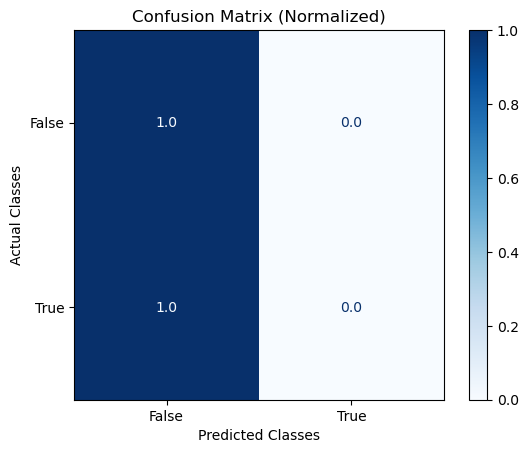

In [26]:
print(classification_report(true_labels, boolean_classifications, labels=[True, False]))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels.tolist(), predict_vector=boolean_classifications
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)